# Import the useful packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from skimage.restoration import richardson_lucy
from skimage.metrics import structural_similarity as ssim
from skimage.data import shepp_logan_phantom
import cv2

In [2]:
DATA_PATH = 'Data/'

# PIS algorithm Code

## Soft-thresholding 


$$ S_{1,\gamma, \mu}(c) = \text{sign}(c) \times \max(|c| -\gamma / \mu, 0) $$ 

In [3]:
def soft_thresholding(x, threshold): # in our context the threshold will be gamma / mu
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

## PIS algorithm

At each iteration of the algorithm : 

$$c_{t+1} =  S_{1,\gamma, \mu}\left(c_t + \dfrac{1}{\mu} A^* \left[\dfrac{g - A[c_t]}{A[c_t]}\right]\right) $$

With the same notations as in the paper we have the written the following algorithm : 

In [4]:
def PIS(g, psf, num_iter=50, gamma=0.01, mu=100):

    def A(x): # calculate A
        return ndi.convolve(x, psf, mode='reflect')  
    
    def A_adj(x): # calculate the adjoint of A
        return ndi.convolve(x, psf[::-1, ::-1], mode='reflect') 
    
    c = np.copy(g) 

    for _ in range(num_iter):
        A_c = A(c)  

        gradient = A_adj((g - A_c) / (A_c + 1e-6)) 

        c = soft_thresholding(c + (1 / mu) * gradient, gamma / mu)

        c = np.maximum(c, 0)

    return c

# With the Shepp-Logan Phantom (as in the paper to first try out the code)

## Load the data and apply the blur and noise

In [ ]:
def apply_blur(image, D):
    sigma = D / 2
    psf_size = int(3 * sigma) * 2 + 1
    x = np.linspace(-psf_size//2, psf_size//2, psf_size)
    psf = np.exp(-(x[:, None]**2 + x[None, :]**2) / (2 * sigma**2))
    psf /= psf.sum()
    blurred = ndi.convolve(image, psf, mode='reflect')
    return blurred, psf

def apply_poisson_noise(image, snr):
    image = np.maximum(image, 0)
    noisy_image = np.random.poisson(image * snr) / snr
    return noisy_image / noisy_image.max() * image.max() 

In [6]:
# Generate test image
d = 2
SnR = 32

image = ndi.zoom(shepp_logan_phantom().astype(np.float32), 0.75)
blurred, psf = apply_blur(image, d)
noisy_image = apply_poisson_noise(blurred, SnR)

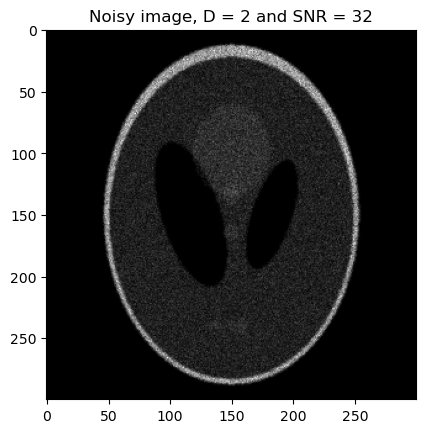

In [7]:
plt.imshow(noisy_image, cmap='grey')
plt.title(f'Noisy image, D = {d} and SNR = {SnR}')
plt.show()

## Apply the Poisson Iterative Shrinkage and Compare with Richardson-Lucy


First we define the Normalized mean squared error, as : 

$$  \text{NMSE} = \mathbb{E} \left[ \dfrac{||f - \tilde{f}||^2_F}{||f||^2_F} \right] $$

In [8]:
def nmse(original, reconstructed):
    return np.linalg.norm(original - reconstructed) ** 2 / np.linalg.norm(original) ** 2

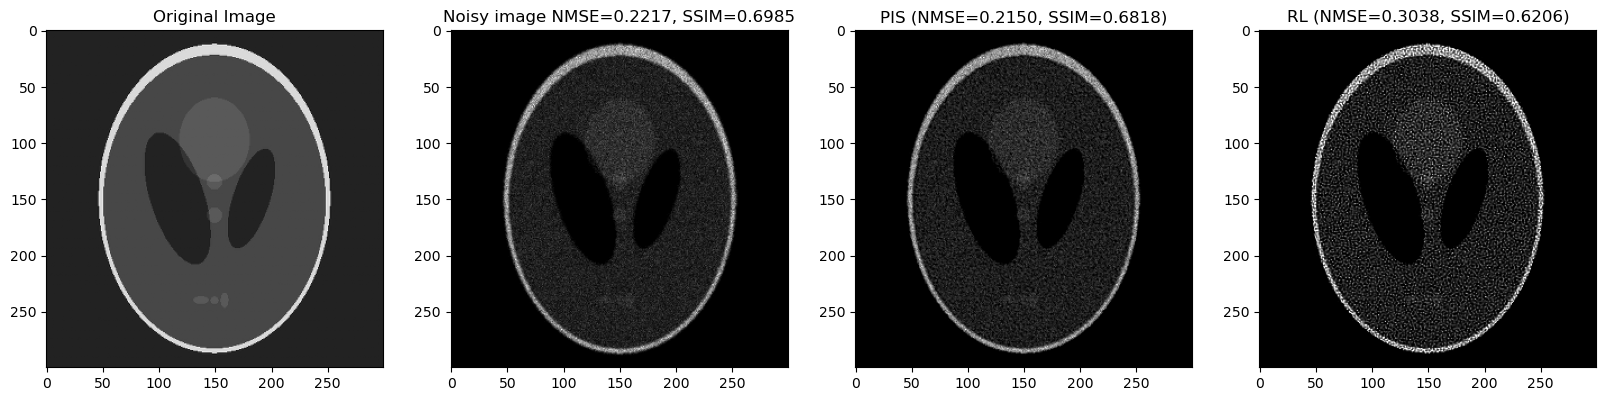

In [ ]:

pis_reconstructed = PIS(noisy_image, psf, num_iter=50)

rl_reconstructed = richardson_lucy(noisy_image, psf, num_iter=50)

nmse_pis = nmse(image, pis_reconstructed)
nmse_rl = nmse(image, rl_reconstructed)
nmse_noisy = nmse(image, noisy_image)

ssim_pis = ssim(image, pis_reconstructed, data_range=image.max())
ssim_rl = ssim(image, rl_reconstructed, data_range=image.max())
ssim_noisy = ssim(image, noisy_image, data_range=image.max())


fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(image, cmap='gray'); axes[0].set_title("Original Image")
axes[1].imshow(noisy_image, cmap='gray'); axes[1].set_title(f"Noisy image NMSE={nmse_noisy:.4f}, SSIM={ssim_noisy:.4f}")
axes[2].imshow(pis_reconstructed, cmap='gray'); axes[2].set_title(f"PIS (NMSE={nmse_pis:.4f}, SSIM={ssim_pis:.4f})")
axes[3].imshow(rl_reconstructed, cmap='gray'); axes[3].set_title(f"RL (NMSE={nmse_rl:.4f}, SSIM={ssim_rl:.4f})")

plt.show()

# With another picture not used in the paper : Astronomical picture

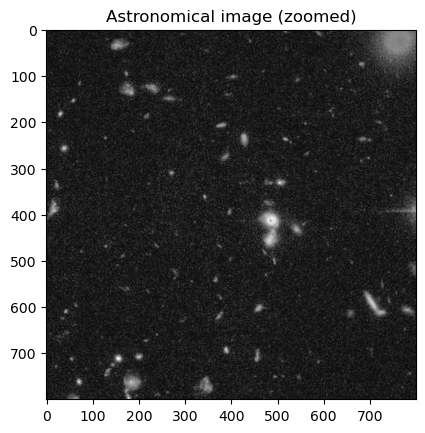

In [ ]:
astro = cv2.imread(DATA_PATH + 'image.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float32)
astro= ndi.zoom(astro, 2)
astro = (astro - astro.min()) / (astro.max() - astro.min() + 1e-8)

x_center, y_center = astro.shape[1] // 2, astro.shape[0] // 2
zoom_size = 400  

astro = astro[y_center - zoom_size:y_center + zoom_size, x_center - zoom_size:x_center + zoom_size]

plt.imshow(astro, cmap='gray')
plt.title("Astronomical image (zoomed)")
plt.show()

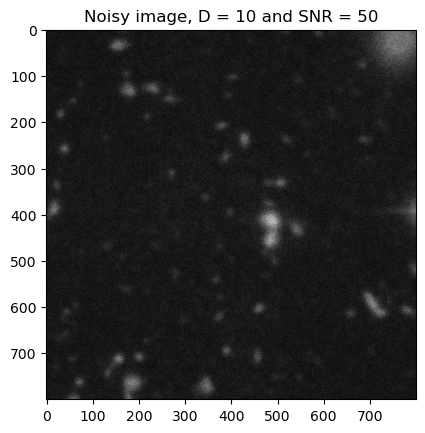

In [11]:
d = 10
SnR = 50

blurred_astro , psf = apply_blur(astro, d)
noisy_astro = apply_poisson_noise(blurred_astro, SnR)

plt.imshow(noisy_astro, cmap='grey')
plt.title(f'Noisy image, D = {d} and SNR = {SnR}')
plt.show()

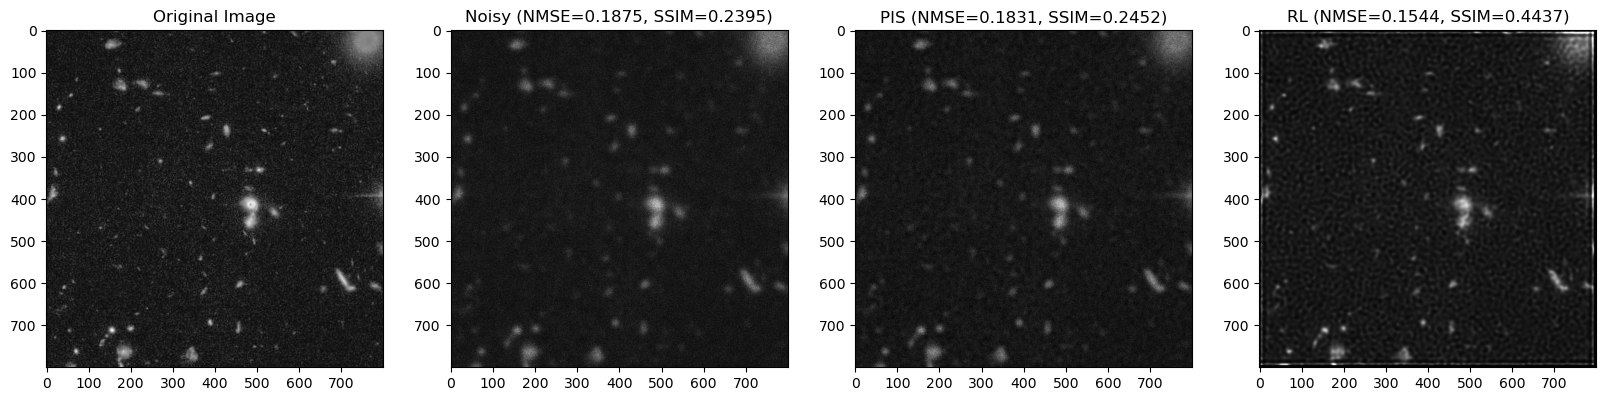

In [ ]:
psf /= psf.sum()
noisy_astro = np.clip(noisy_astro, 1e-8, None) 
noisy_astro = (noisy_astro - noisy_astro.min()) / (noisy_astro.max() - noisy_astro.min() + 1e-8)


rl_reconstructed = richardson_lucy(noisy_astro, psf, num_iter=50)

pis_reconstructed = PIS(noisy_astro, psf, num_iter=50)


nmse_pis = nmse(astro, pis_reconstructed)
nmse_rl = nmse(astro, rl_reconstructed)
nmse_noisy = nmse(astro, noisy_astro)

ssim_pis = ssim(astro, pis_reconstructed, data_range=astro.max())
ssim_rl = ssim(astro, rl_reconstructed, data_range=astro.max())
ssim_noisy = ssim(astro, noisy_astro, data_range=astro.max())

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(astro, cmap='gray'); axes[0].set_title("Original Image")
axes[1].imshow(noisy_astro, cmap='gray'); axes[1].set_title(f"Noisy (NMSE={nmse_noisy:.4f}, SSIM={ssim_noisy:.4f})")
axes[2].imshow(pis_reconstructed, cmap='gray'); axes[2].set_title(f"PIS (NMSE={nmse_pis:.4f}, SSIM={ssim_pis:.4f})")
axes[3].imshow(rl_reconstructed, cmap='gray'); axes[3].set_title(f"RL (NMSE={nmse_rl:.4f}, SSIM={ssim_rl:.4f})")

#plt.savefig('Picture.pdf')
plt.show()